<h1>Import packages<h1>

In [1]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

<h1>Read the files</h1>

In [2]:
raster_loc = r"C:\Users\DELL\Desktop\machine_learning\rasters\RASTER.tif"
points_loc = r"C:\Users\DELL\Desktop\machine_learning\Samples\samples.shp"
temp_point_loc = r"C:\Users\DELL\Desktop\machine_learning\copy\copy.shp"

# land cover names (for post visualization)
lulc_name = ['Water bodies', 'built up', 'vegetation', 'Barren Land', 'Agriculture']

In [3]:
raster = rio.open(raster_loc)

<h1>Normalize the bands to a fixed scale(0-1)</h1>

In [4]:
blue = raster.read(1, masked=True)
green = raster.read(2, masked=True)
red = raster.read(3, masked=True)
nir = raster.read(4, masked=True)
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)


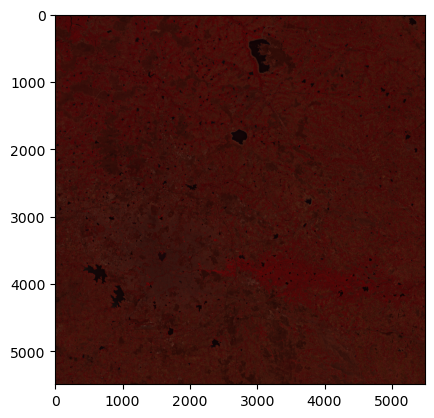

In [5]:
rgb = np.dstack((nirn, redn, greenn))
plt.imshow(rgb)

Text(0.5, 1.0, 'Blue')

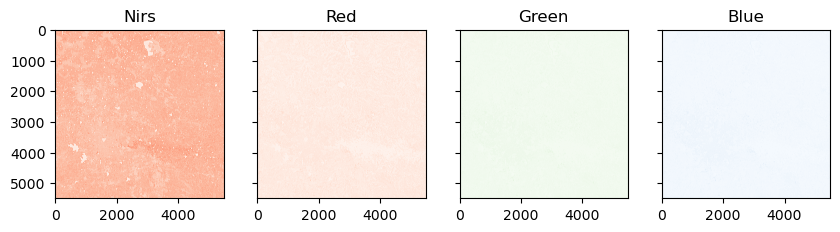

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show(nirn, ax=ax1, cmap= 'Reds')
show(redn, ax=ax2, cmap = 'Reds')
show(greenn, ax=ax3, cmap='Greens')
show(bluen, ax=ax4, cmap='Blues')

# Add titles
ax1.set_title("Nirs")
ax2.set_title("Red")
ax3.set_title("Green")
ax4.set_title("Blue")

<h1>divide samples into training and testing sites</h1>

In [13]:
#  reading bands from input
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
points = points[points['labels']!=55]
# adding a new column 'id' with range of points
points = points.assign(id=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_loc) 
# converting gdf to pd df and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))

# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']
Sampled Data: 
      band1  band2  band3  band4   id  labels
0     1286   1575   1442   1139    0     1.0
1     1487   1793   1527   1513    1     1.0
2     1258   1519   1296   1296    2     1.0
3     1336   1574   1389   1344    3     1.0
4     1178   1388   1276   1065    4     1.0
..     ...    ...    ...    ...  ...     ...
259   1162   1582   1526   4275  259     5.0
260   1396   1916   3017   3895  260     5.0
261   1829   2524   3718   4546  261     5.0
262   1421   1971   3183   4030  262     5.0
263   1307   1707   2771   3612  263     5.0

[264 rows x 6 columns]
X_train Shape: (184, 4)
X_test Shape: (80, 4)
y_train Shape: (184,)
y_test Shape:(80,)


<h1>Train SVM classifier</h1>

Accuracy SVM: 76.25
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        15
         2.0       0.65      0.69      0.67        16
         3.0       0.70      0.93      0.80        15
         4.0       0.60      0.20      0.30        15
         5.0       0.78      0.95      0.86        19

    accuracy                           0.76        80
   macro avg       0.75      0.75      0.72        80
weighted avg       0.75      0.76      0.73        80

Confusion Matrix RF: 
 [[15  0  0  0  0]
 [ 0 11  3  1  1]
 [ 0  0 14  1  0]
 [ 0  5  3  3  4]
 [ 0  1  0  0 18]]


Text(48.65624999999999, 0.5, 'Actual')

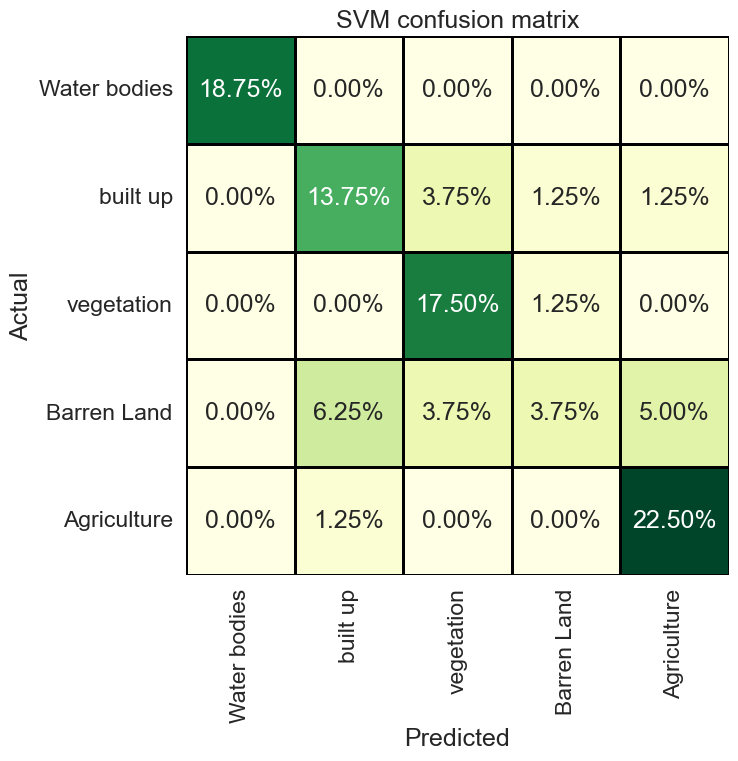

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName+' confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

<h1>Train decision trees classifier</h1>

Accuracy DT: 78.75
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        15
         2.0       0.86      0.75      0.80        16
         3.0       0.86      0.80      0.83        15
         4.0       0.53      0.53      0.53        15
         5.0       0.73      0.84      0.78        19

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80

Confusion Matrix RF: 
 [[15  0  0  0  0]
 [ 0 12  1  2  1]
 [ 0  0 12  3  0]
 [ 0  1  1  8  5]
 [ 0  1  0  2 16]]
CPU times: total: 93.8 ms
Wall time: 338 ms


Text(48.65624999999999, 0.5, 'Actual')

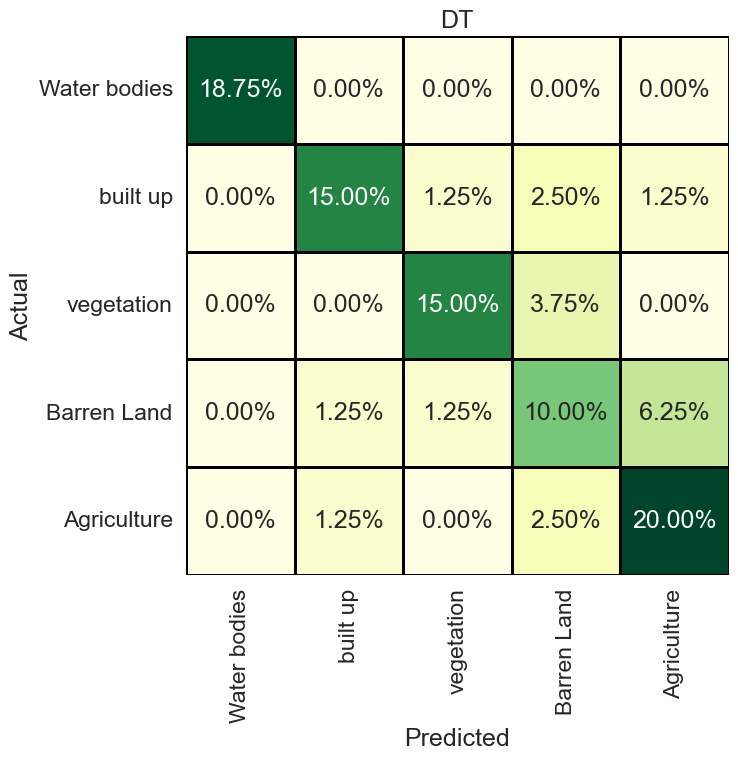

In [18]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cName = 'DT'

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

<h1>Train Random Forest Classifier</h1>

Accuracy RF: 80.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        15
         2.0       0.77      0.62      0.69        16
         3.0       0.93      0.87      0.90        15
         4.0       0.57      0.53      0.55        15
         5.0       0.75      0.95      0.84        19

    accuracy                           0.80        80
   macro avg       0.80      0.79      0.80        80
weighted avg       0.80      0.80      0.80        80

Confusion Matrix RF: 
 [[15  0  0  0  0]
 [ 0 10  1  4  1]
 [ 0  0 13  2  0]
 [ 0  2  0  8  5]
 [ 0  1  0  0 18]]
CPU times: total: 422 ms
Wall time: 883 ms


Text(48.65624999999999, 0.5, 'Actual')

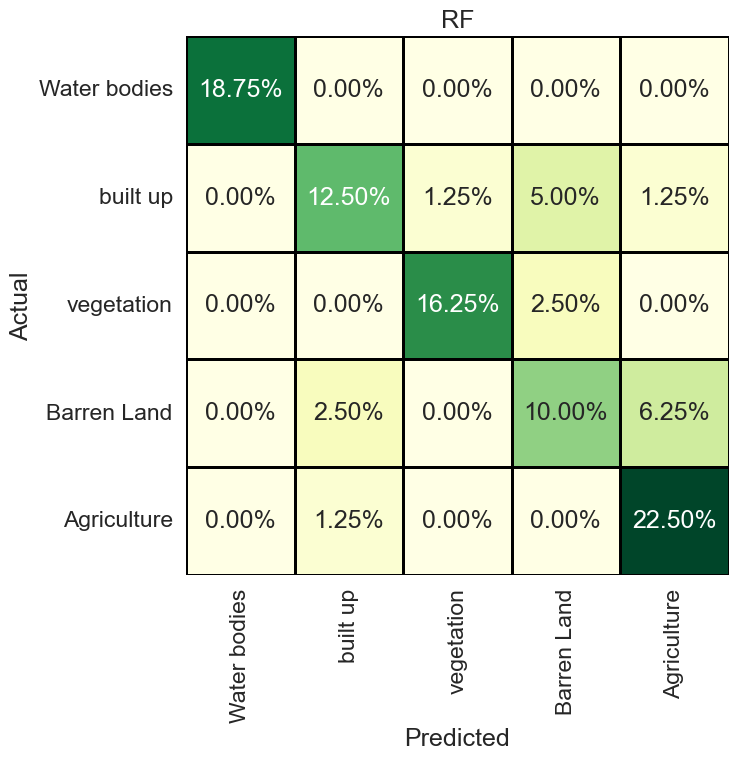

In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

<h1>Export the output</h1>

In [25]:
%%time

cName = 'RF'
exp_name = r"C:\Users\DELL\Desktop\machine_learning\output\output.tif"


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 5490
Width: 5490
Bands: 4

reshaped full data shape  for prediction:  (30140100, 4)
Prediction Done, now exporting raster 

Map saved RF.................
CPU times: total: 4min 41s
Wall time: 14min 40s


In [30]:
%%time
cName = 'SVM'
exp_name = r"C:\Users\DELL\Desktop\machine_learning\output\svm.tif"


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 5490
Width: 5490
Bands: 4

reshaped full data shape  for prediction:  (30140100, 4)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: total: 5min 3s
Wall time: 8min 2s


<h1>plotting the lulc map<h1>

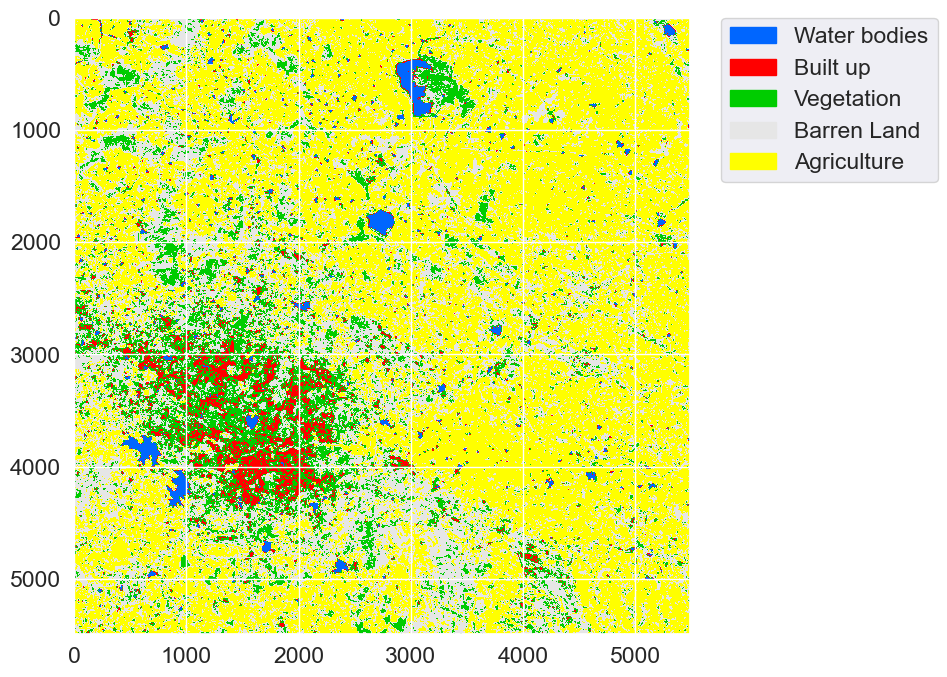

In [32]:
#classied map by random forest

# Load your raster data
raster_loc = r"C:\Users\DELL\Desktop\machine_learning\output\output.tif"

# Define your LULC class names and their corresponding colors
lulc_names = ['Water bodies', 'Built up', 'Vegetation', 'Barren Land', 'Agriculture']
lulc_colors = ['#0066ff', '#ff0000', '#00cc00', '#e6e6e6', '#ffff00']

# Open the exported raster
with rio.open(raster_loc) as src:
    # Read raster data
    raster = src.read(1)

# Create a colormap from the list of colors
cmap = ListedColormap(lulc_colors)

# Plot the raster
plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap=cmap)

# Create legend patches for each class
legend_patches = [Patch(color=color, label=label) for color, label in zip(lulc_colors, lulc_names)]

# Add legend to the plot
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()
